Week 9 · Day 3 — LSTM & GRU Cells
Why this matters

Vanilla RNNs forget long-term information due to vanishing gradients. LSTMs and GRUs fix this with gating mechanisms, making them the backbone of modern NLP (natural langauge processors) before Transformers.

Theory Essentials

LSTM (Long Short-Term Memory): adds gates (input, forget, output) + cell state to preserve long-term info.

GRU (Gated Recurrent Unit): simplified version with update/reset gates, fewer parameters.

Tradeoff: LSTM = more expressive but heavier; GRU = lighter, often similar performance.

Key idea: gating decides what information to keep, update, or forget.

When to use: LSTM for complex tasks, GRU when speed/resources are limited.

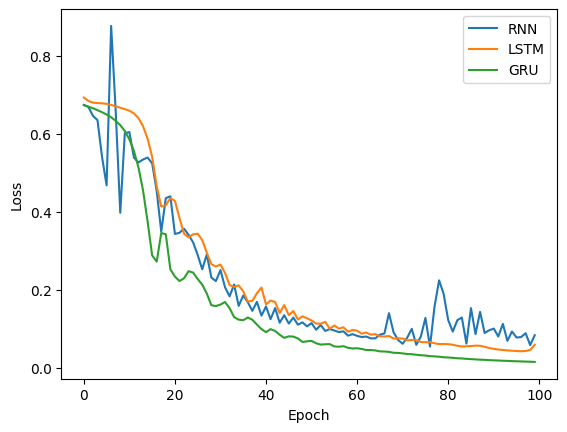

In [ ]:
# Setup (same)
import numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
import random

# --- Reproducibility (NEW) ---
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Toy dataset (same API; MORE DATA for stability)
def make_dataset(n=6000, seq_len=20):  
    X, y = [], []
    for _ in range(n):
        seq = np.random.randint(0, 2, size=seq_len)
        X.append(seq)
        y.append(int(seq.sum() > (seq_len//2)))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y)

X, y = make_dataset(6000, seq_len=20)  
train_X, train_y = X[:5000], y[:5000]
val_X,   val_y   = X[5000:], y[5000:]

# Base class (keeps your structure)
class RNNModel(nn.Module):
    def __init__(self, rnn_type="RNN", hidden_dim=32):
        super().__init__()
        # --- Param-matched hidden sizes (NEW) ---
        # RNN params ~ h^2 + 3h ; GRU ~ 3*(h^2 + 3h); LSTM ~ 4*(h^2 + 3h)
        # If RNN uses h=32 → GRU≈19, LSTM≈17 to be roughly similar total params.
        if rnn_type == "RNN":
            h = 32
            self.rnn = nn.RNN(1, h, batch_first=True)
        elif rnn_type == "LSTM":
            h = 17  # CHANGED
            self.rnn = nn.LSTM(1, h, batch_first=True)
        elif rnn_type == "GRU":
            h = 19  # CHANGED
            self.rnn = nn.GRU(1, h, batch_first=True)
        self.fc = nn.Linear(h, 2)
    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.rnn(x)
        return self.fc(out[:,-1,:])

# Training loop 
def train(model, X, y, epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)  
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

# Compare RNN vs LSTM vs GRU (same structure; fixed seeds per model)
results = {}
for rnn_type in ["RNN","LSTM","GRU"]:
    torch.manual_seed(SEED)  # CHANGED: same init each time for fairness
    model = RNNModel(rnn_type)
    results[rnn_type] = train(model, train_X, train_y)

for k,v in results.items():
    plt.plot(v, label=k)
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()


1) Core (10–15 min)
Task: Train all three (RNN, LSTM, GRU) for 15 epochs. Which converges faster?

In [18]:
for rnn_type in results:
    print(rnn_type, "Final loss:", results[rnn_type][-1])


RNN Final loss: 0.08318661898374557
LSTM Final loss: 0.05877602472901344
GRU Final loss: 0.014776652678847313


2) Practice (10–15 min)
Task: Record training time per epoch for each model.

In [19]:
import time
for rnn_type in ["RNN","LSTM","GRU"]:
    start = time.time()
    train(RNNModel(rnn_type), train_X, train_y)
    print(rnn_type, "time:", time.time()-start)


RNN time: 3.473433017730713
LSTM time: 5.9176836013793945
GRU time: 10.922350645065308


3) Stretch (optional, 10–15 min)
Task: Increase sequence length to 50. Compare performance. Which model handles longer dependencies best?

In [21]:
X, y = make_dataset(6000, seq_len=50)  
train_X, train_y = X[:5000], y[:5000]
for rnn_type in ["RNN","LSTM","GRU"]:
    model = RNNModel(rnn_type)
    losses = train(model, train_X, train_y)
    print(rnn_type, "Final loss:", losses[-1])


RNN Final loss: 0.6732946038246155
LSTM Final loss: 0.09865211695432663
GRU Final loss: 0.05284140631556511


Mini-Challenge (≤40 min)

Build a comparison table:

Train RNN, LSTM, and GRU on the toy dataset (seq_len=30).

Report: final accuracy, training time, #parameters.

Acceptance Criteria: Table with rows (RNN/LSTM/GRU), columns (accuracy, params, time).

In [24]:
import pandas as pd

X, y = make_dataset(6000, seq_len=30)
train_X, train_y = X[:5000], y[:5000]
val_X,   val_y   = X[5000:], y[5000:]

def count_params(m):
    return sum(p.numel() for p in m.parameters())

def evaluate_acc(model, X, y):
    with torch.no_grad():
        logits = model(X)
        preds = logits.argmax(1)
        return (preds == y).float().mean().item()

rows = []
for rnn_type in ["RNN", "LSTM", "GRU"]:
    torch.manual_seed(SEED)  # same init per model for fairness
    model = RNNModel(rnn_type, hidden_dim=32)
    train_time = train(model, train_X, train_y, epochs=100)
    acc = evaluate_acc(model, val_X, val_y)
    params = count_params(model)
    rows.append({"cell": rnn_type, "accuracy": acc, "params": params, "time_sec": train_time})

df = pd.DataFrame(rows).set_index("cell").sort_index()
print(df.round(4))

      accuracy  params                                           time_sec
cell                                                                     
GRU      1.000    1294  [0.6836591958999634, 0.6778000593185425, 0.675...
LSTM     0.982    1396  [0.6925825476646423, 0.6865398287773132, 0.684...
RNN      0.952    1186  [0.6797022819519043, 0.6850911378860474, 0.664...


Notes / Key Takeaways

RNNs quickly lose long-term context.

LSTMs solve this with gates and a persistent cell state.

GRUs simplify gating with fewer parameters, often nearly as effective.

Tradeoff: LSTM = more capacity, GRU = efficiency.

In practice, GRU often wins when speed is more important than small accuracy gains.

Parameter counts grow with hidden size.

Tomorrow we’ll introduce word embeddings.

Reflection

Why do gates help LSTMs remember longer dependencies?

When might you prefer a GRU over an LSTM?


**Why do gates help LSTMs remember longer dependencies?**
The gates (input, forget, output) control what information to keep, update, or discard in the cell state. This lets the LSTM maintain a stable memory signal over many timesteps, avoiding vanishing gradients. As a result, LSTMs can “carry forward” relevant information much longer than vanilla RNNs.

---

**When might you prefer a GRU over an LSTM?**
GRUs are simpler (fewer gates, fewer parameters) and often train faster with less data. You’d prefer GRUs when you want similar performance to LSTMs but with lower computational cost, smaller models, or when the dataset/task is not very complex.

---

👉 Quick memory hook:

* **LSTM = stronger memory** (thanks to gates).
* **GRU = lighter, faster choice** when you don’t need the full complexity of LSTM.
